In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import numpy as np

df = pd.read_csv("data/NIST_Visc_data.csv")

feats = pd.DataFrame(df, columns=["MolFrac_1", "T"])
data = pd.DataFrame(df, columns=["MOL_1", "MOL_2", "Visc"])


feats.to_csv("data/features1.csv", index=False)
data.to_csv("data/data1.csv", index=False)

df = pd.read_csv("ManyProp/data/data.csv")

data_list = [] 
for idx, row in df.iterrows():
    smi1 = row['MOL_1']
    smi2 = row['MOL_2']
    mol1 = MoleculeModel(smi1, 0.5)()
    mol2 = MoleculeModel(smi2, 0.5)()
    target = row['logV']
    data_list.append((MixtureDataset([mol1, mol2], float(target))))

data_list = [ds.to_tuple() for ds in data_list]

In [2]:
from ManyProp.args import Args
from ManyProp.model.train import run_training
from ManyProp.data.data_pipeline import parse_data

In [3]:
args = Args()
args().epochs = 30
#args().num_folds = 2
#args().num_layers=2
#args().dropout=0.1
#args().data_points=40
#args().data_path="./data/data1.csv"
#args().features_path="./data/features1.csv"
#args().smiles_columns=['MOL_1', 'MOL_2']
#args().targets_column=['logV']
#args().mol_frac_columns=['MolFrac_1']
args().normalize = True
args().log = True

args().loss_function = "SmoothL1"

data = pd.read_csv(args().data_path)
feat_data = pd.read_csv(args().mol_features_path) 

all_data = pd.concat([data, feat_data], axis=1)
all_data.head()

data_list = parse_data(args=args,num_dp=100)

pd.DataFrame(data_list[:10]).head()

from ManyProp.utils import make_splits

train_data, val_data, test_data = make_splits(args=args, data_list=data_list)

dl = make_dl(args=args, data_list=data_list)
train_dl = make_dl(args=args, data_list=train_data)
val_dl = make_dl(args=args, data_list=val_data)
test_dl = make_dl(args=args, data_list=test_data)

In [4]:
import matplotlib.pyplot as plt

In [ ]:
losses = run_training(args=args)#, train_dl=train_dl, val_dl=val_dl) 

[08:16:21] WARNING: not removing hydrogen atom without neighbors
[08:16:22] WARNING: not removing hydrogen atom without neighbors


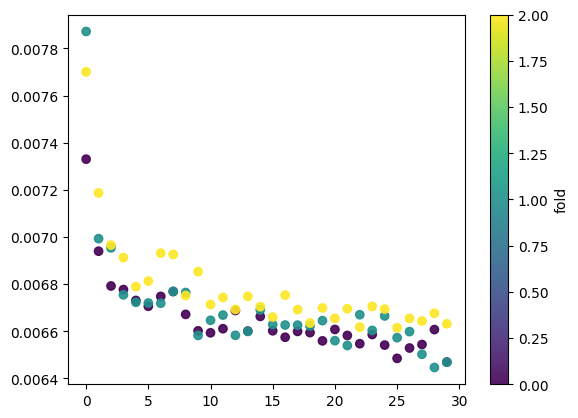

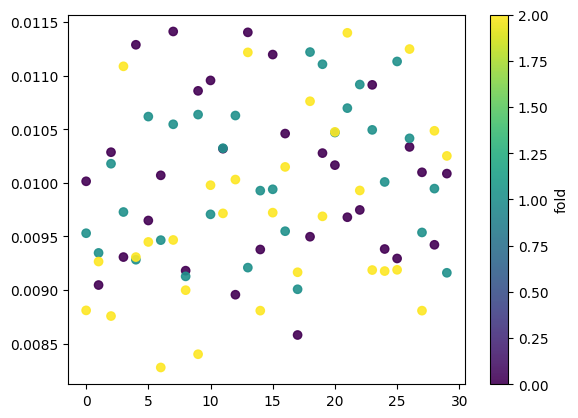

In [ ]:
x = np.array([tup[1] for tup in losses])
y = np.array([tup[2] for tup in losses])

c = np.array([tup[0] for tup in losses])

plt.scatter(x, y, c=c, cmap='viridis', alpha=0.9)
plt.colorbar(label="fold")

plt.show()
y = np.array([tup[3] for tup in losses])
plt.scatter(x, y, c=c, cmap='viridis', alpha=0.9)
plt.colorbar(label="fold")

plt.show()

In [ ]:
def make_plot(idx, losses_arr, title):
    fold_losses = []

    for n in range(args().num_folds):
        fold_losses.append([])
        for tup in losses_arr:
            if tup[0]==n:
                fold_losses[n].append(tup[idx])

    avg_losses = []
    avg_vars = []
    for e in range(args().epochs):
        losses_arr = []
        
        for f in fold_losses:
            losses_arr.append(f[e])
        avg_losses.append(np.mean(losses_arr).item())
        avg_vars.append(np.var(losses_arr).item())
    x=range(args().epochs)
    a, b = np.polyfit(x, avg_losses, 1)

    plt.errorbar(x=x,y=avg_losses, yerr=avg_vars, fmt='o', capsize=5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(title)
    plt.plot(x, a*x+b)
    plt.show()

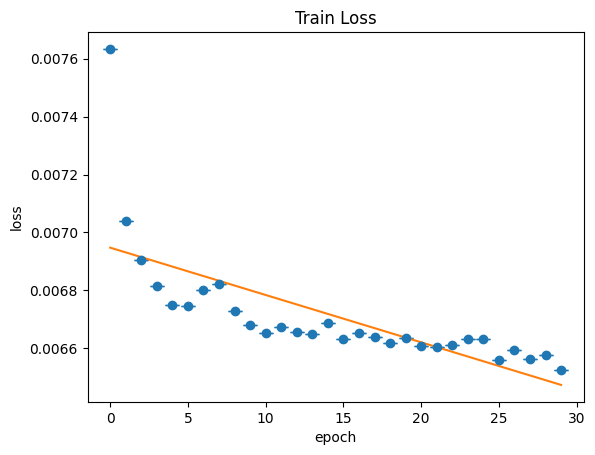

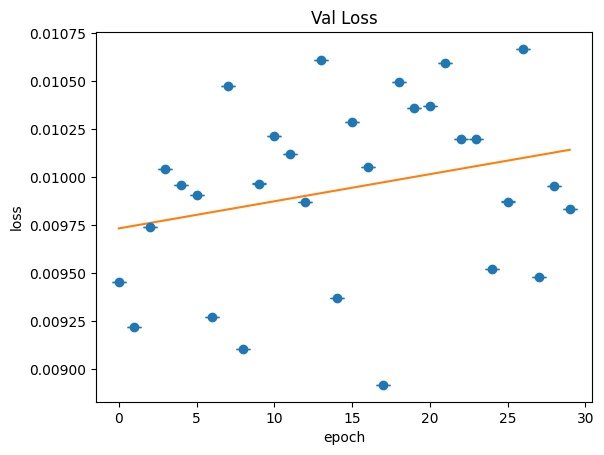

In [ ]:
make_plot(2, losses_arr=losses, title="Train Loss")
make_plot(3, losses_arr=losses, title="Val Loss")

In [ ]:
from ManyProp.data.testing import rand_mol


In [ ]:
mol1 = rand_mol()
mol2 = rand_mol()

[08:29:29] Explicit valence for atom # 19 N, 4, is greater than permitted
[08:29:29] Can't kekulize mol.  Unkekulized atoms: 25 26 27
[08:29:29] SMILES Parse Error: syntax error while parsing: CC=(O)(=O)C=1CCCCC1c1ccccc1(N(O)=O)CC(O)c1ccccc1CC
[08:29:29] SMILES Parse Error: check for mistakes around position 4:
[08:29:29] CC=(O)(=O)C=1CCCCC1c1ccccc1(N(O)=O)CC(O)c
[08:29:29] ~~~^
[08:29:29] SMILES Parse Error: Failed parsing SMILES 'CC=(O)(=O)C=1CCCCC1c1ccccc1(N(O)=O)CC(O)c1ccccc1CC' for input: 'CC=(O)(=O)C=1CCCCC1c1ccccc1(N(O)=O)CC(O)c1ccccc1CC'
[08:29:29] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:29:29] Explicit valence for atom # 3 N, 4, is greater than permitted
[08:29:29] SMILES Parse Error: syntax error while parsing: C(N(O)=O)C(CC)=(CCC)C=CCCC
[08:29:29] SMILES Parse Error: check for mistakes around position 16:
[08:29:29] C(N(O)=O)C(CC)=(CCC)C=CCCC
[08:29:29] ~~~~~~~~~~~~~~~^
[08:29:29] SMILES Parse Error: Failed parsing SMILES 'C(N(O)=O)C(CC)=(CCC)C=CCCC

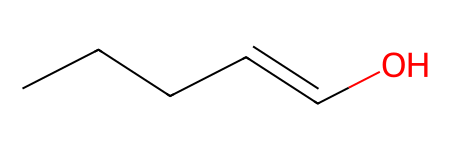

In [ ]:
Chem.MolFromSmiles(mol1)

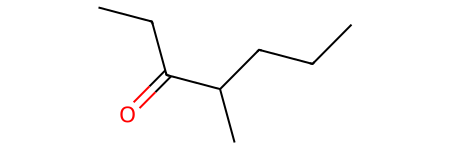

In [ ]:
Chem.MolFromSmiles(mol2)

In [ ]:
from ManyProp.model.predict import predict
#["COCCOC","CCCN"]
args().smiles = [mol1,mol2]
args().mol_fracs = [0.25, 0.75]
pred, var = predict(args=args)
print(f"prediction: {pred} - var: {var}")

model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
prediction: 0.8471879230676305 - var: 0.006505434635026297


10**pred

model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:

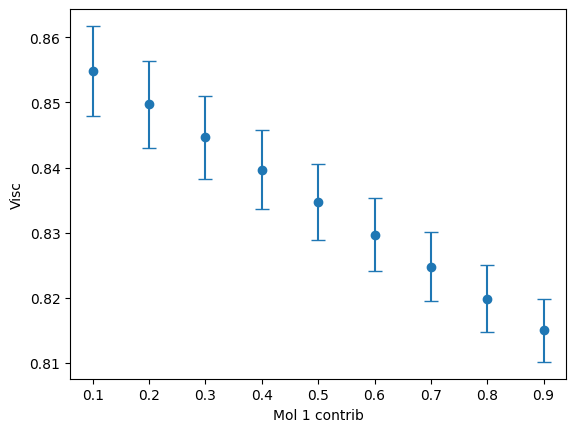

In [ ]:
from ManyProp.model.predict import predict_graph
import matplotlib.pyplot as plt
fracs, predictions, vars = predict_graph(args)

plt.xlabel("Mol 1 contrib")
plt.ylabel("Visc")
plt.errorbar(x=fracs,y=predictions, yerr=vars, fmt='o', capsize=5)
plt.show()


0.10665317578241229 

0.9376093910024833
1.4904445287051609

In [ ]:
from ManyProp.args import Args
args = Args()
#args().data_points = 40
args().num_folds = 5
args().lightningMPNN = True
from ManyProp.model.train import lightning_train

losses = lightning_train(args=args)


[09:28:19] WARNING: not removing hydrogen atom without neighbors
[09:28:22] WARNING: not removing hydrogen atom without neighbors
[09:28:24] WARNING: not removing hydrogen atom without neighbors
[09:28:28] WARNING: not removing hydrogen atom without neighbors
[09:28:30] WARNING: not removing hydrogen atom without neighbors
[09:28:41] WARNING: not removing hydrogen atom without neighbors
[09:28:46] WARNING: not removing hydrogen atom without neighbors
[09:28:48] WARNING: not removing hydrogen atom without neighbors
[09:28:57] WARNING: not removing hydrogen atom without neighbors
[09:28:58] WARNING: not removing hydrogen atom without neighbors
[09:29:00] WARNING: not removing hydrogen atom without neighbors
[09:29:04] WARNING: not removing hydrogen atom without neighbors
[09:29:21] WARNING: not removing hydrogen atom without neighbors
[09:29:24] WARNING: not removing hydrogen atom without neighbors
[09:29:28] WARNING: not removing hydrogen atom without neighbors
[09:29:44] WARNING: not r

fold: 0
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 389. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]saved_model
                                                                           

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 358. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2726/2726 [00:23<00:00, 118.18it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 407. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 428. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 423. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we 

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 403. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 415. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 383. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we 

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 427. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 355. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 424. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we 

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 418. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 395. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 419. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we 

Validation DataLoader 0:  29%|██▉       | 99/341 [00:00<00:02, 112.83it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 402. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 447. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 399. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we 

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 366. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 422. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 453. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we 

Validation DataLoader 0:  45%|████▍     | 153/341 [00:01<00:01, 114.06it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 376. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 416. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 404. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we 

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 319. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 356. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 379. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we 

Validation DataLoader 0:  60%|█████▉    | 204/341 [00:01<00:01, 114.82it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 344. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 435. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 348. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 346. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 365. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we 

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 446. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 360. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 380. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 324. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 345. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 1:   1%|          | 15/2726 [00:00<00:32, 84.42it/s, v_num=63]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 286. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1: 100%|██████████| 2726/2726 [00:26<00:00, 102.37it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 478. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 431. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Validation DataLoader 0:  18%|█▊        | 62/341 [00:00<00:02, 118.33it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 359. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 436. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 442. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 331. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 336. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 351. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 452. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 347. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 357. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 437. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 439. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 445. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 2: 100%|██████████| 2726/2726 [00:27<00:00, 100.66it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 463. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 461. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 462. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 333. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 337. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 443. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation DataLoader 0:  51%|█████     | 173/341 [00:01<00:01, 116.50it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 458. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 341. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 454. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 3:   1%|          | 15/2726 [00:00<00:31, 85.85it/s, v_num=63]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 282. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation DataLoader 0:   8%|▊         | 28/341 [00:00<00:02, 109.43it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 342. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 329. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 448. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 474. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 338. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 450. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 325. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 4:   1%|          | 14/2726 [00:00<00:31, 85.61it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 451. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 317. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 4: 100%|██████████| 2726/2726 [00:27<00:00, 98.84it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 335. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 466. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 343. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 339. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 330. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 5:   1%|          | 16/2726 [00:00<00:29, 90.50it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 287. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 5: 100%|██████████| 2726/2726 [00:26<00:00, 101.59it/s, v_num=63]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 473. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 470. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 456. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation DataLoader 0:  15%|█▍        | 51/341 [00:00<00:02, 120.72it/s]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 460. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation DataLoader 0:  41%|████      | 140/341 [00:01<00:01, 117.13it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 328. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 6:   1%|          | 16/2726 [00:00<00:30, 90.12it/s, v_num=63]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 291. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 6: 100%|██████████| 2726/2726 [00:26<00:00, 101.57it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 455. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 323. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation DataLoader 0:  25%|██▌       | 86/341 [00:00<00:02, 116.96it/s]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 322. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation DataLoader 0:  62%|██████▏   | 211/341 [00:01<00:01, 116.30it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 467. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 318. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 340. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 465. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation DataLoader 0:  88%|████████▊ | 299/341 [00:02<00:00, 116.59it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 321. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 276. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 7: 100%|██████████| 2726/2726 [00:27<00:00, 97.39it/s, v_num=63] 

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 334. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 476. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 8:   0%|          | 13/2726 [00:00<00:34, 79.05it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 304. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 8: 100%|██████████| 2726/2726 [00:29<00:00, 91.05it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 483. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 472. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 475. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 9:   1%|          | 14/2726 [00:00<00:34, 77.71it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 267. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 9: 100%|██████████| 2726/2726 [00:30<00:00, 88.67it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 495. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 10:   1%|          | 15/2726 [00:00<00:31, 84.85it/s, v_num=63] 

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 313. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 10: 100%|██████████| 2726/2726 [00:29<00:00, 93.76it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 479. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 332. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 11:   1%|          | 15/2726 [00:00<00:32, 84.49it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 257. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 11: 100%|██████████| 2726/2726 [00:28<00:00, 96.66it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 327. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 12:   0%|          | 10/2726 [00:00<00:45, 60.03it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 303. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 12: 100%|██████████| 2726/2726 [00:27<00:00, 99.49it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 489. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 490. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 471. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 13: 100%|██████████| 2726/2726 [00:28<00:00, 97.13it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 326. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Validation DataLoader 0:  71%|███████▏  | 243/341 [00:02<00:00, 111.02it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 487. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 15:   1%|          | 15/2726 [00:00<00:31, 85.48it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 293. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 17: 100%|██████████| 2726/2726 [00:31<00:00, 87.83it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 480. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 18:   1%|          | 15/2726 [00:00<00:30, 87.93it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 285. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 20:   0%|          | 10/2726 [00:00<00:47, 57.69it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 306. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 20: 100%|██████████| 2726/2726 [00:32<00:00, 83.90it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 469. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 21: 100%|██████████| 2726/2726 [00:29<00:00, 91.04it/s, v_num=63]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 482. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 23:   1%|          | 15/2726 [00:00<00:32, 83.62it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 272. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 23: 100%|██████████| 2726/2726 [00:29<00:00, 93.65it/s, v_num=63]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 493. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 24: 100%|██████████| 2726/2726 [00:29<00:00, 91.60it/s, v_num=63]/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 468. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 25:   0%|          | 13/2726 [00:00<00:36, 73.52it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 316. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 25: 100%|██████████| 2726/2726 [00:30<00:00, 88.70it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 491. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 320. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 27:   1%|          | 14/2726 [00:00<00:34, 77.75it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 270. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 28:   1%|          | 15/2726 [00:00<00:33, 82.05it/s, v_num=63]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 311. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 29: 100%|██████████| 2726/2726 [00:42<00:00, 63.68it/s, v_num=63]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 277. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 2726/2726 [00:42<00:00, 63.66it/s, v_num=63]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing DataLoader 0:   3%|▎         | 11/341 [00:00<00:04, 72.62it/s]

c:\Users\cbh2\Documents\ManyProp\ManyProp\model\mpnn.py:168: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(preds, targets)


Testing DataLoader 0:  84%|████████▍ | 288/341 [00:02<00:00, 101.79it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 506. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Testing DataLoader 0: 100%|██████████| 341/341 [00:03<00:00, 101.50it/s]


c:\Users\cbh2\Documents\ManyProp\ManyProp\model\mpnn.py:168: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(preds, targets)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.2082613706588745     │
└───────────────────────────┴───────────────────────────┘

[09:46:37] WARNING: not removing hydrogen atom without neighbors
[09:46:46] WARNING: not removing hydrogen atom without neighbors
[09:46:50] WARNING: not removing hydrogen atom without neighbors
[09:46:57] WARNING: not removing hydrogen atom without neighbors
[09:47:03] WARNING: not removing hydrogen atom without neighbors
[09:47:21] WARNING: not removing hydrogen atom without neighbors
[09:47:22] WARNING: not removing hydrogen atom without neighbors
[09:47:33] WARNING: not removing hydrogen atom without neighbors
[09:47:35] WARNING: not removing hydrogen atom without neighbors
[09:47:36] WARNING: not removing hydrogen atom without neighbors
[09:47:45] WARNING: not removing hydrogen atom without neighbors
[09:47:46] WARNING: not removing hydrogen atom without neighbors
[09:47:55] WARNING: not removing hydrogen atom without neighbors
[09:47:56] WARNING: not removing hydrogen atom without neighbors
[09:48:00] WARNING: not removing hydrogen atom without neighbors
[09:48:01] WARNING: not r

fold: 1
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 61.46it/s]saved_model
                                                                           

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2726/2726 [00:30<00:00, 90.61it/s, v_num=64]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 312. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 1:   0%|          | 5/2726 [00:00<00:34, 78.14it/s, v_num=64]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 485. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 296. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 4:   0%|          | 11/2726 [00:00<00:43, 61.72it/s, v_num=64]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 274. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 5:   1%|          | 15/2726 [00:00<00:32, 83.68it/s, v_num=64]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 308. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 7:   0%|          | 9/2726 [00:00<00:49, 54.87it/s, v_num=64]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 288. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 13:   0%|          | 10/2726 [00:00<00:47, 57.07it/s, v_num=64]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 294. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 14:   0%|          | 11/2726 [00:00<00:42, 63.15it/s, v_num=64]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 302. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 16: 100%|██████████| 2726/2726 [00:39<00:00, 69.47it/s, v_num=64]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 481. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 18:   0%|          | 10/2726 [00:00<00:47, 57.52it/s, v_num=64]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 307. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 20:   0%|          | 11/2726 [00:00<00:42, 64.46it/s, v_num=64]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 305. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 21:   0%|          | 10/2726 [00:00<00:45, 60.34it/s, v_num=64]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 273. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 23:   0%|          | 9/2726 [00:00<00:47, 56.92it/s, v_num=64]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 309. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 26: 100%|██████████| 2726/2726 [00:40<00:00, 67.88it/s, v_num=64]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 315. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation DataLoader 0:  90%|████████▉ | 306/341 [00:05<00:00, 59.94it/s]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 477. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 27:   0%|          | 11/2726 [00:00<00:44, 61.03it/s, v_num=64]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 269. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 27: 100%|██████████| 2726/2726 [00:36<00:00, 75.39it/s, v_num=64]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 314. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 28: 100%|██████████| 2726/2726 [00:36<00:00, 73.84it/s, v_num=64]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 486. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 29:   1%|          | 16/2726 [00:00<00:32, 84.27it/s, v_num=64]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 300. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 29: 100%|██████████| 2726/2726 [00:42<00:00, 64.78it/s, v_num=64]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 265. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 2726/2726 [00:42<00:00, 64.75it/s, v_num=64]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing DataLoader 0:   3%|▎         | 9/341 [00:00<00:04, 70.82it/s]

c:\Users\cbh2\Documents\ManyProp\ManyProp\model\mpnn.py:168: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(preds, targets)


Testing DataLoader 0: 100%|██████████| 341/341 [00:03<00:00, 95.50it/s]


c:\Users\cbh2\Documents\ManyProp\ManyProp\model\mpnn.py:168: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(preds, targets)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.2961634397506714     │
└───────────────────────────┴───────────────────────────┘

[10:08:38] WARNING: not removing hydrogen atom without neighbors
[10:08:44] WARNING: not removing hydrogen atom without neighbors
[10:08:51] WARNING: not removing hydrogen atom without neighbors
[10:08:56] WARNING: not removing hydrogen atom without neighbors
[10:08:59] WARNING: not removing hydrogen atom without neighbors
[10:09:14] WARNING: not removing hydrogen atom without neighbors
[10:09:19] WARNING: not removing hydrogen atom without neighbors
[10:09:20] WARNING: not removing hydrogen atom without neighbors
[10:09:22] WARNING: not removing hydrogen atom without neighbors
[10:09:31] WARNING: not removing hydrogen atom without neighbors
[10:09:35] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:45] WARNING: not removing hydrogen atom without neighbors
[10:09:47] WARNING: not removing hydrogen atom without neighbors
[10:09:52] WARNING: not removing hydrogen atom without neighbors
[10:09:57] WARNING: not r

fold: 2
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 50.89it/s]saved_model
                                                                           

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 2726/2726 [00:35<00:00, 77.41it/s, v_num=65]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 492. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 4:   0%|          | 11/2726 [00:00<00:42, 64.42it/s, v_num=65]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 278. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 7:   0%|          | 11/2726 [00:00<00:43, 61.94it/s, v_num=65]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 254. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 9:   0%|          | 9/2726 [00:00<00:50, 54.27it/s, v_num=65]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 283. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 10:   0%|          | 9/2726 [00:00<00:50, 54.07it/s, v_num=65]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 292. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 10: 100%|██████████| 2726/2726 [00:35<00:00, 76.73it/s, v_num=65]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 496. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 11:   0%|          | 9/2726 [00:00<00:45, 59.93it/s, v_num=65]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 284. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 12:   0%|          | 8/2726 [00:00<00:53, 51.02it/s, v_num=65]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 281. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 13:   0%|          | 12/2726 [00:00<00:41, 64.92it/s, v_num=65]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 280. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 14: 100%|██████████| 2726/2726 [00:35<00:00, 75.85it/s, v_num=65]


c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 505. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 16:   0%|          | 10/2726 [00:00<00:46, 58.09it/s, v_num=65]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 299. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 18:   0%|          | 9/2726 [00:00<00:49, 54.42it/s, v_num=65]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 290. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 20: 100%|██████████| 2726/2726 [00:37<00:00, 72.96it/s, v_num=65]

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 503. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


saved_model
Epoch 24:   0%|          | 10/2726 [00:00<00:45, 59.67it/s, v_num=65]  

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 264. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 28:   0%|          | 9/2726 [00:00<00:51, 52.74it/s, v_num=65]   

c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 295. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 29: 100%|██████████| 2726/2726 [00:43<00:00, 62.70it/s, v_num=65]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 2726/2726 [00:43<00:00, 62.68it/s, v_num=65]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\cbh2\Documents\ManyProp\manypropenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.



Testing DataLoader 0:   5%|▍         | 17/341 [00:00<00:03, 99.66it/s]

c:\Users\cbh2\Documents\ManyProp\ManyProp\model\mpnn.py:168: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(preds, targets)


Testing DataLoader 0: 100%|██████████| 341/341 [00:03<00:00, 102.98it/s]


c:\Users\cbh2\Documents\ManyProp\ManyProp\model\mpnn.py:168: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(preds, targets)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.3579626083374023     │
└───────────────────────────┴───────────────────────────┘

In [2]:
losses

{'fold0': {'train_loss': [1.667163372039795,
   0.4470544159412384,
   1.427443504333496,
   2.2684755325317383,
   0.29825955629348755,
   0.3055921196937561,
   1.9011995792388916,
   0.841486394405365,
   0.30113449692726135,
   0.4426226019859314,
   1.9316496849060059,
   0.293582022190094,
   1.2095180749893188,
   0.3280033469200134,
   1.4501725435256958,
   0.14536058902740479,
   0.47205400466918945,
   0.11430133134126663,
   1.2222295999526978,
   1.7357717752456665,
   1.2840492725372314,
   0.561168372631073,
   0.892882764339447,
   1.5466504096984863,
   0.24487340450286865,
   0.6131241917610168,
   0.42044827342033386,
   1.129939317703247,
   0.5516575574874878,
   0.6826590299606323,
   0.318320095539093,
   1.056361198425293,
   0.1524210274219513,
   0.33664044737815857,
   1.4112467765808105,
   0.10430953651666641,
   0.6722389459609985,
   0.3834324777126312,
   0.4027704894542694,
   0.4330926537513733,
   0.9815769791603088,
   2.002910852432251,
   0.9678617

In [3]:
from ManyProp.model.predict import predict
pred = predict(args=args)

model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>
model_loaded:  <All keys matched successfully>


In [5]:
pred[0].item()

0.8647794728286865

In [4]:
10**pred[0].item()

7.3245251206968485

In [ ]:
0.8647794728286865